# Ridge regression with polynomial features of degree 2
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [ ]:
%autosave 0
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
import pickle
import os
import scipy.stats as st

In [ ]:
from azureml.logging import get_azureml_logger
run_logger = get_azureml_logger()
run_logger.log(“amlrealworld.timeseries.ridge-poly”,”true”)

In [2]:
model_name = "ridge_poly2"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(os.path.join(aml_dir, 'nyc_demand_train.csv'), parse_dates=['timeStamp'])

Create model pipeline:
- one-hot encode categorical features.
- create polynomial features of degree 2. This means that for each pair of features $(x_1, x_2)$, the output features are $(x_1, x_2, x_1^2, x_1x_2, x_2^2)$
- randomized parameter search with cross validation to find optimal values for the alpha parameter

Note - to limit the training time, the number of iterations for the randomized search has been set to 20. This should train in about 3 minutes. increasing the number of iterations will increase the likelihood of finding the optimum solution but also increase training times. 

In [3]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [4]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)
regr = Ridge(fit_intercept=False)
poly = PolynomialFeatures(2)
tscv = TimeSeriesSplit(n_splits=3)

In [5]:
param_dist = {'alpha': st.uniform(1e-4, 5.0)}
regr_cv = RandomizedSearchCV(estimator=regr,
                            param_distributions=param_dist,
                            n_iter=20,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            cv=tscv,
                            verbose=2,
                            n_jobs=-1)
regr_pipe = Pipeline([('onehot', onehot), ('poly', poly), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.9min finished


Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[2, 3, 4], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(max_trai...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [6]:
with open(os.path.join(aml_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [7]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
6,6.967113,0.054570,-1239.941008,-1043.671720,0.823993,{'alpha': 0.823992609583},1,-1373.599007,-1010.979826,-1078.278786,-1076.410326,-1267.945231,-1043.625009,2.063244,0.009279,122.179337,26.711910
18,6.053257,0.046879,-1239.987894,-1043.334590,0.786296,{'alpha': 0.786295596025},2,-1373.671040,-1010.403637,-1078.268489,-1076.150007,-1268.024152,-1043.450127,0.808095,0.000005,122.216176,26.840967
19,4.720967,0.040608,-1240.090268,-1042.766007,0.723847,{'alpha': 0.72384706818},3,-1373.845160,-1009.436284,-1078.256388,-1075.707183,-1268.169257,-1043.154553,0.249660,0.006745,122.296096,27.056376
1,6.456279,0.061546,-1240.333833,-1041.797919,0.621137,{'alpha': 0.621136886756},4,-1374.294583,-1007.801768,-1078.254279,-1074.941341,-1268.452635,-1042.650646,0.776875,0.016696,122.482558,27.416247
9,5.895548,0.062501,-1240.695363,-1050.001444,1.59318,{'alpha': 1.59318117995},5,-1376.045406,-1022.095643,-1078.787157,-1081.099964,-1267.253526,-1046.808724,1.685731,0.012756,122.799616,24.193974


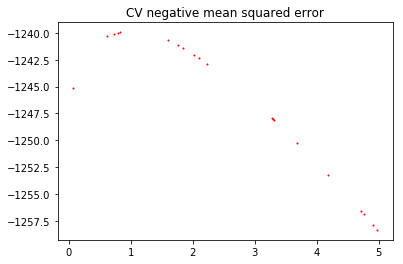

In [8]:
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'ro', markersize=1)
plt.title('CV negative mean squared error')
plt.show()